<a href="https://colab.research.google.com/github/eitellauria/Retention/blob/main/Freshmen_Retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freshmen_Retention


In [1]:
!pip install fancyimpute --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls /gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy

retentionAugmented2016.csv  test_S2_withS1_LogReg.csv	train_S2_withS1_XGBoost.csv
retentionAugmented2017.csv  test_S2_withS1_XGBoost.csv
retentionAugmented2018.csv  train_S2_withS1_LogReg.csv


In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
#from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from fancyimpute import KNN

#from bayes_opt import BayesianOptimization

## Execution parameters

In [5]:
#datapth
datapath = '/gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy/'

#output path
outputpath =  '/gdrive/MyDrive/Research/Retention/RetentionCommittee/Legacy/'

# Semester
semester = 1

# Impute
impute = True

# Balance data through weighted classes
balance = False

# Columns to normalize
#normalizationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM"]
#normalizationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_ROOM"]

# Columns to impute
# Columns with nulls:
# Significantly filled with nulls, so don't impute: HSClassPercentile, APTITUDE_SCORE
#imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM"]
#imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES",  "OCCUPANTS_ROOM"]
imputationColumns = ["FinAidRating", "DISTANCE_IN_MILES", "OCCUPANTS_BLDG", "OCCUPANTS_ROOM", "APTITUDE_SCORE"]

# Number of Iterations in Bayesian optimization
ITERATIONS = 20 # 100

# Training File Name
trainName = 'retentionAugmented2016.csv'
train_namelist = ['retentionAugmented2016.csv','retentionAugmented2017.csv']

# Testing File Name
testName = 'retentionAugmented2018.csv'

After executing the cell above, a new file named 'Sample file.txt' will appear in your [drive.google.com](https://drive.google.com/) file list.

## Helper Functions

In [58]:
def read_traning_data (datapath, namelist):
    for i,filename in enumerate(namelist):
        print(filename)
        if i==0:
           dfr  = pd.read_csv(datapath+filename).drop(['AdmissionYear'], axis=1)
        else:
           #dfx  = pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)
           dfr  = pd.concat([dfr, pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)], ignore_index=True)
    return dfr
#------------------------------------------------------------------------------------------------------------------------------
def CustomKNNImpute (df,df_types, k_neighbors=3):
    """ Replace the missing values within the value coming from the k neighbors
        Assumes that the dataframe is made up of numerical values which are either floating point ('f'), binary flags ('b'), or multi_category ('c')
        These data types should be provided as a dictionary (df_types) which can be created with the statement:
          df_types = dict(zip(df.columns.to_list(), list_of_data_types))
        For example:
          df_types = dict(zip(df.columns.to_list(), ['b','b','b','f','f','c']))

        @params:
            - df                            = a dataframe to be imputed
            - df_types                      = a dictionary of datatypes, indexed by the column names
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
        @returns:
             - df_imputed                   = the imputed dataframe
    """
    #from sklearn.impute import KNNImputer
    #imputer = KNNImputer(n_neighbors=k_neighbors)

    imputer = KNN(k=k_neighbors)   # using fancyimputer instead

    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns= df.columns)

    for x in df_types:
     if df_types[x] in ['b','c']:
        df_imputed[x]=df_imputed[x].round(decimals=0)

    return df_imputed
#----------------------------------------------------------------------------------------------------------------------------------------------
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr, pearsonr

def phi_coefficient(x, y):
    # A simplified Phi coefficient calculation assuming binary variables coded as 0 and 1
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = len(x)
    phi = np.sqrt(chi2 / n)
    return phi

def calculate_correlation(x, y):
    if set(x.unique()) == {0, 1} and set(y.unique()) == {0, 1}: # Both binary
        return phi_coefficient(x, y)
    elif set(x.unique()) == {0, 1} or set(y.unique()) == {0, 1}: # One binary, one continuous
        return pointbiserialr(x, y)[0]
    else: # Both continuous
        return pearsonr(x, y)[0]

def mixed_type_correlation_matrix(data):
    corr_matrix = pd.DataFrame(index=data.columns, columns=data.columns, dtype=float)
    for col1 in data.columns:
        for col2 in data.columns:
            if data[col1].dtype == 'O' or data[col2].dtype == 'O': # Skip non-numeric columns
                corr_matrix.loc[col1, col2] = np.nan
            else:
                corr_matrix.loc[col1, col2] = calculate_correlation(data[col1], data[col2])
    return corr_matrix

# Example usage
# df = pd.DataFrame(...) # Your DataFrame here
# correlation_matrix = mixed_type_correlation_matrix(df)
# print(correlation_matrix)


#-----------------------------------------------------------------------------------------------------------------------------------------------
import statsmodels.api as sm
from scipy.stats import chi2
from scipy.stats import norm

class LogisticRegressionStatsModel:
    def __init__(self, feature_names, target_name):
        self.feature_names = feature_names
        self.target_name = target_name
        self.X_columns =None
        self.model = None
        self.results = None

    def fit(self, X_train, y_train):
        # Fit the logistic regression model using statsmodels
        X_train = sm.add_constant(X_train)
        model = sm.Logit(y_train, X_train)
        self.results = model.fit(maxiter=500,method='bfgs') #bfgs
        self.model = model
        self.X_columns =X_train.columns

    def predict_proba(self, X_data):
        # Add constant term to new data and predict probabilities
        X_data = sm.add_constant(X_data)
        return self.results.predict(X_data)

    def predict(self, X_data, threshold=0.5):
        # Predict class labels based on a probability threshold
        probabilities = self.predict_proba(X_data)
        return (probabilities >= threshold).astype(int)

    def get_summary(self):
      top_summary_data = {
        'Dep. Variable': self.target_name,
        'No. Observations': len(X_train),
        'Method': 'MLE',
        'Model': 'Logit',
        'Df Residuals': self.results.df_resid,
        'Chi-Square': self.results.llr,
        'Chi-Square p-value': self.results.llr_pvalue,
        'Df Model (Chi-Square Test)': self.results.df_model,
        'Pseudo R-squ.': self.results.prsquared,
        'Log-Likelihood': self.results.llf,
        'LL-Null': self.results.llnull,
        'LLR p-value': self.results.llr_pvalue,
        'AIC': self.results.aic,
        'converged': self.results.mle_retvals['converged']
      }
      summary = pd.DataFrame([top_summary_data])
      return summary

    def get_coef_summary(self):
      # Calculate Wald test for individual coefficients
      wald_chi2 = (self.results.params / self.results.bse)**2
      wald_p_values = 1 - chi2.cdf(wald_chi2, df=1)

      # Create a DataFrame with coefficient information
      coef_summary_data = {
        #'Coefficient': self.X_columns,
        'Coefficient Value': self.results.params,
        'Standard Error': self.results.bse,
        # The statsmodels library uses normal test, the Wald test is more standard.
        #'Z-Score': self.results.tvalues,
        #'P>|z|': 2 * (1 - norm.cdf(np.abs(self.results.tvalues))),
        'Wald Test Chi2': wald_chi2,
        #'Wald Test P>|Chi2|': wald_p_values,
        #'Odds Ratio': np.exp(self.results.params)
        'Wald Test P>|Chi2|': np.round(wald_p_values,4),
        'Odds Ratio': np.round(np.exp(self.results.params),4)
      }
      coef_summary = pd.DataFrame(coef_summary_data)
      return coef_summary

#----------------------------------------------------------------------------------------------------------

def plot_binary_distributions(y_train, y_test):
    # Calculate counts and proportions for both y_train and y_test
    train_counts = y_train.value_counts().sort_index()
    train_proportions = y_train.value_counts(normalize=True).sort_index()
    test_counts = y_test.value_counts().sort_index()
    test_proportions = y_test.value_counts(normalize=True).sort_index()

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Function to add labels
    def add_labels(ax, counts, proportions):
        for i in ax.patches:
            # Get X and Y coordinates of each bar
            x = i.get_x() + i.get_width() / 2
            y = i.get_height()
            # Adjust y position for label (adding some space)
            label_y = y - 0.1
            # Count label
            count_label = f'{counts[int(i.get_x() + 0.5)]}'
            # Proportion label (formatted as percentage)
            proportion_label = f'{proportions[int(i.get_x() + 0.5)]:.2%}'
            ax.annotate(f'{count_label}\n({proportion_label})', (x, label_y), ha='center')

    # Plot for y_train
    train_proportions.plot(kind='bar', ax=axes[0], color=['cyan', 'orange'])
    axes[0].set_title('Proportions in training')
    axes[0].set_xlabel('Attrited')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticklabels(['0', '1'], rotation=0)
    add_labels(axes[0], train_counts, train_proportions)

    # Plot for y_test
    test_proportions.plot(kind='bar', ax=axes[1], color=['cyan', 'orange'])
    axes[1].set_title('Proportions in testing')
    axes[1].set_xlabel('Attrited')
    axes[1].set_ylabel('Proportion')
    axes[1].set_xticklabels(['0', '1'], rotation=0)
    add_labels(axes[1], test_counts, test_proportions)

    # Adjust layout to make sure labels fit
    plt.tight_layout()

    # Show plot
    plt.show()

# Usage example
# plot_binary_distributions(y_train_data, y_test_data)

#---------------------------------------------------------------------------------------------
def plot_overlayed_proportions(y_train, y_test, var_col, train_data, test_data):
    def calculate_relative_proportions(y, var, data):
        # Combine the y Series with the specified column from the data DataFrame
        combined = pd.concat([y, data[var]], axis=1, keys=['attrited', 'var'])
        # Grouping by the binary variable and the categorical variable
        group_counts = combined.groupby(['attrited', 'var']).size().unstack(fill_value=0)
        # Calculating the relative proportions
        relative_proportions = group_counts.div(group_counts.sum(axis=1), axis=0)
        return relative_proportions

    # Calculate relative proportions for train and test sets
    train_proportions = calculate_relative_proportions(y_train, var_col, train_data)
    test_proportions = calculate_relative_proportions(y_test, var_col, test_data)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plot for y_train
    train_plot = train_proportions.plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_title('training')
    axes[0].set_xlabel('Class')

    # Plot for y_test
    test_plot = test_proportions.plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_title('test')
    axes[1].set_xlabel('Class')

    # Set a common Y label
    fig.text(0.04, 0.1, 'Proportion', va='center', rotation='horizontal')

    # Create a single legend outside of the main frame
    # Get handles and labels from one of the plots
    handles, labels = axes[0].get_legend_handles_labels()
    # Place the legend outside the plot area
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.8, 0.5), title=var_col)

    # Adjust layout to make sure labels and legend fit
    plt.subplots_adjust(right=0.8)

    # Remove individual legends from subplots
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()

    # Show plot
    plt.show()


# Usage example
# plot_overlayed_proportions(y_train_data, y_test_data, 'var_column' , train_data, test_data)



## Main

In [7]:
#dfr  = pd.read_csv(datapath+trainName).drop(['AdmissionYear'], axis=1)
dfr= read_traning_data (datapath, train_namelist)
dft  = pd.read_csv(datapath+testName).drop(['AdmissionYear'], axis=1)

retentionAugmented2016.csv
retentionAugmented2017.csv


In [8]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EarlyAction             2430 non-null   int64  
 1   EarlyDecision           2430 non-null   int64  
 2   MeritScholAmt           2430 non-null   int64  
 3   FinAidRating            2426 non-null   float64
 4   HSTier                  2430 non-null   int64  
 5   AttritFall              2430 non-null   int64  
 6   AttritSpring            2430 non-null   int64  
 7   Attrited                2430 non-null   int64  
 8   Foreign                 2430 non-null   int64  
 9   FAFSA                   2430 non-null   int64  
 10  APCourses               2430 non-null   int64  
 11  Male                    2430 non-null   int64  
 12  Minority                2430 non-null   int64  
 13  Athlete                 2430 non-null   int64  
 14  earlyDeferal            2430 non-null   

## Exclude features

In [9]:
## remove features here ex1 and ex[n] are used to create exclude_always
# just to keep things organized
#

ex1 = ['Mid_Fall_GPA', 'Mid_Fall_Cred_Regstr', 'HSClassPercentile'] # , 'OCCUPANTS_BLDG''HSClassPercentile', 'APTITUDE_SCORE'
ex2 = ['PP_GPA', 'PP_Involve', 'PP_Rm_Cond', 'PP_Rm_Damg', 'PP_Dscpln', 'PP_Other']
# from augmented data, generalized by zip code
ex3 = ['percentHigherEd', 'giniIndex', 'medianIncome', 'percentWithInternet','percentMinority']
ex4 = ['APTITUDE_SCORE', 'Race_W', 'School_SM']
exclude_always = ex1 + ex2 + ex3 + ex4


if (semester==1) :   # exclude first smester GPA
   excluded_fields = ['AttritFall','AttritSpring', 'Attrited', 'FS_GPA_NUM' ] + exclude_always
if (semester == 2) : # filter those gone after first semester
  dfr  = dfr[dfr.AttritFall!= 1]
  dft  = dft[dft.AttritFall!= 1]
  excluded_fields = ['AttritFall','AttritSpring', 'Attrited'] + exclude_always

#X_train, y_train =dfr.drop(excluded_fields, axis=1), dfr[['AttritFall']].values.flatten()
#X_test, y_test =dft.drop(excluded_fields, axis=1), dft[['AttritFall']].values.flatten()

X_train, y_train =dfr.drop(excluded_fields, axis=1), dfr[['Attrited']]
X_test, y_test =dft.drop(excluded_fields, axis=1), dft[['Attrited']]


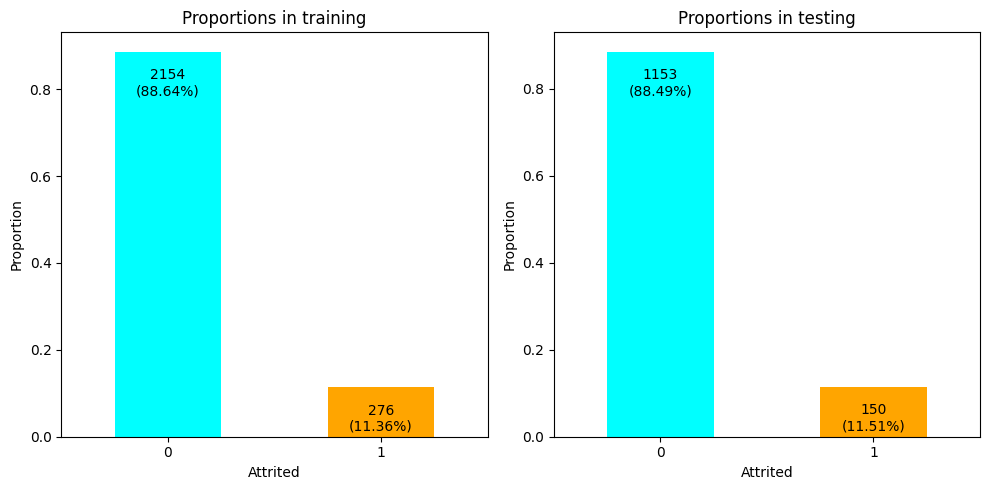

In [10]:
plot_binary_distributions(y_train, y_test)

In [11]:
X_train

,EarlyAction,EarlyDecision,MeritScholAmt,FinAidRating,HSTier,Foreign,FAFSA,APCourses,Male,Minority,...,Race_N,Race_O,Race_P,isPellRecipient,ISDEANSLIST,ISPROBATION,OCCUPANTS_BLDG,OCCUPANTS_ROOM,IS_SINGLE_ROOM,IS_UNLIMITED_MEAL_PLAN
0,0,0,0,NaN,3,0,0,1,1,0,...,0,0,0,0,0,0,NaN,NaN,0,0
1,0,0,10,NaN,2,0,0,1,0,0,...,0,0,0,0,0,0,NaN,NaN,0,0
2,0,1,0,7.0,3,0,0,1,0,0,...,0,0,0,0,0,0,157.0,3.0,0,1
3,0,1,0,7.0,2,0,0,1,0,0,...,0,0,0,0,0,0,147.0,2.0,0,1
4,0,0,0,9.0,1,0,1,0,0,0,...,0,0,0,1,0,0,25.0,25.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,0,0,0,8.0,3,0,1,0,0,0,...,0,0,0,0,0,0,365.0,3.0,0,1
2426,1,0,0,7.0,3,0,0,0,1,0,...,0,0,0,0,0,0,157.0,5.0,0,1
2427,0,0,0,9.0,2,1,0,0,1,0,...,0,0,0,0,0,0,421.0,2.0,0,1
2428,0,0,0,9.0,1,1,0,0,1,1,...,0,0,0,0,0,0,NaN,NaN,0,0


In [12]:
print(f'training shape:{dfr.shape} ,test shape:{dft.shape}')

training shape:(2430, 58) ,test shape:(1303, 58)


## Show Null Values

<Axes: >

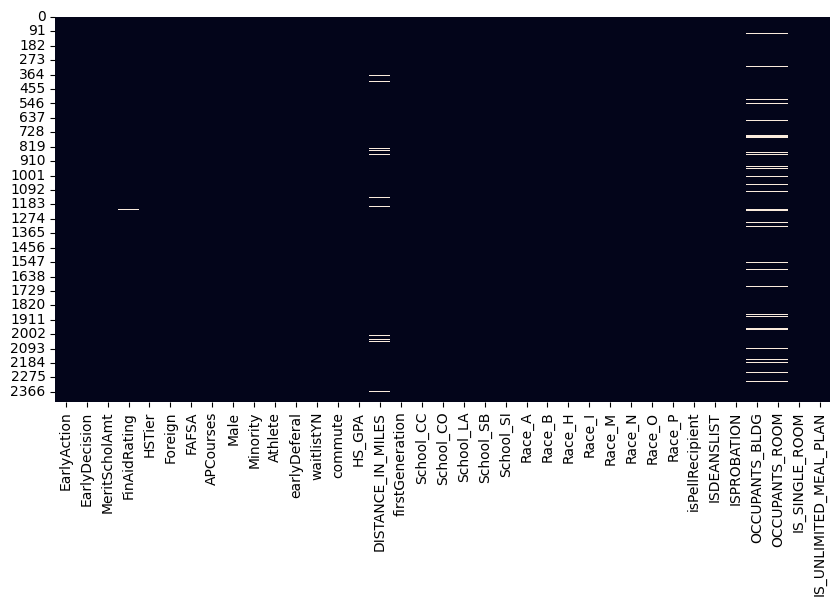

In [13]:
sns.heatmap(X_train.isnull(), cbar=False)

# Impute Data

In [14]:
#df_types = {'EarlyAction': 'b', 'EarlyDecision': 'b', 'MeritScholAmt': 'f', 'FinAidRating': 'f', 'HSTier': 'c', 'Foreign': 'b',
# 'FAFSA': 'b', 'APCourses': 'b', 'Male': 'b', 'Minority': 'b', 'Athlete': 'b', 'earlyDeferal': 'b', 'waitlistYN': 'b',
# 'commute': 'b', 'HS_GPA': 'f', 'DISTANCE_IN_MILES': 'f', 'APTITUDE_SCORE': 'f', 'firstGeneration': 'b', 'School_CC': 'b',
# 'School_CO': 'b', 'School_LA': 'b', 'School_SB': 'b', 'School_SI': 'b', 'School_SM': 'b', 'Race_A': 'b', 'Race_B': 'b',
# 'Race_H': 'b', 'Race_I': 'b', 'Race_M': 'b', 'Race_N': 'b', 'Race_O': 'b', 'Race_P': 'b', 'Race_W': 'b', 'isPellRecipient': 'b',
# 'ISDEANSLIST': 'b', 'ISPROBATION': 'b', 'OCCUPANTS_BLDG': 'f', 'OCCUPANTS_ROOM': 'f', 'IS_SINGLE_ROOM': 'b', 'IS_UNLIMITED_MEAL_PLAN': 'b'}

df_types = {'EarlyAction': 'b', 'EarlyDecision': 'b', 'MeritScholAmt': 'f', 'FinAidRating': 'f', 'HSTier': 'c', 'Foreign': 'b',
 'FAFSA': 'b', 'APCourses': 'b', 'Male': 'b', 'Minority': 'b', 'Athlete': 'b', 'earlyDeferal': 'b', 'waitlistYN': 'b',
 'commute': 'b', 'HS_GPA': 'f', 'DISTANCE_IN_MILES': 'f', 'firstGeneration': 'b', 'School_CC': 'b',
 'School_CO': 'b', 'School_LA': 'b', 'School_SB': 'b', 'School_SI': 'b', 'Race_A': 'b', 'Race_B': 'b',
 'Race_H': 'b', 'Race_I': 'b', 'Race_M': 'b', 'Race_N': 'b', 'Race_O': 'b', 'Race_P': 'b', 'isPellRecipient': 'b',
 'ISDEANSLIST': 'b', 'ISPROBATION': 'b', 'OCCUPANTS_BLDG': 'f', 'OCCUPANTS_ROOM': 'f', 'IS_SINGLE_ROOM': 'b', 'IS_UNLIMITED_MEAL_PLAN': 'b'}

k_neighbors = 5
Xr_imputed  = CustomKNNImpute (X_train,df_types, k_neighbors)
Xt_imputed  = CustomKNNImpute (X_test,df_types, k_neighbors)


Imputing row 1/2430 with 3 missing, elapsed time: 2.208
Imputing row 101/2430 with 2 missing, elapsed time: 2.210
Imputing row 201/2430 with 0 missing, elapsed time: 2.212
Imputing row 301/2430 with 0 missing, elapsed time: 2.213
Imputing row 401/2430 with 0 missing, elapsed time: 2.214
Imputing row 501/2430 with 0 missing, elapsed time: 2.215
Imputing row 601/2430 with 0 missing, elapsed time: 2.216
Imputing row 701/2430 with 0 missing, elapsed time: 2.217
Imputing row 801/2430 with 0 missing, elapsed time: 2.219
Imputing row 901/2430 with 0 missing, elapsed time: 2.220
Imputing row 1001/2430 with 0 missing, elapsed time: 2.222
Imputing row 1101/2430 with 0 missing, elapsed time: 2.223
Imputing row 1201/2430 with 0 missing, elapsed time: 2.224
Imputing row 1301/2430 with 0 missing, elapsed time: 2.226
Imputing row 1401/2430 with 0 missing, elapsed time: 2.227
Imputing row 1501/2430 with 0 missing, elapsed time: 2.228
Imputing row 1601/2430 with 0 missing, elapsed time: 2.230
Imputing 

In [15]:
# Identify columns that contain only zeros
columns_with_zeros =[col for col in Xr_imputed.columns if Xr_imputed[col].eq(0).all()]
columns_with_zeros

['earlyDeferal', 'Race_A', 'Race_H', 'Race_M', 'Race_N']

In [16]:
Xr_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EarlyAction             2430 non-null   float64
 1   EarlyDecision           2430 non-null   float64
 2   MeritScholAmt           2430 non-null   float64
 3   FinAidRating            2430 non-null   float64
 4   HSTier                  2430 non-null   float64
 5   Foreign                 2430 non-null   float64
 6   FAFSA                   2430 non-null   float64
 7   APCourses               2430 non-null   float64
 8   Male                    2430 non-null   float64
 9   Minority                2430 non-null   float64
 10  Athlete                 2430 non-null   float64
 11  earlyDeferal            2430 non-null   float64
 12  waitlistYN              2430 non-null   float64
 13  commute                 2430 non-null   float64
 14  HS_GPA                  2430 non-null   

In [17]:
# Identify columns that contain only zeros
columns_with_zeros =[col for col in Xr_imputed.columns if Xr_imputed[col].eq(0).all()]
columns_with_zeros
X_trn_subset= Xr_imputed.drop(columns_with_zeros,axis=1)
X_tst_subset= Xt_imputed.drop(columns_with_zeros,axis=1)

In [18]:
subset = ['EarlyAction', 'EarlyDecision', 'MeritScholAmt', 'FinAidRating',
           'HSTier', 'Foreign', 'FAFSA', 'APCourses', 'Male', 'Minority',
           'Athlete', 'waitlistYN', 'commute',  'HS_GPA',
           'School_CC', 'School_CO','School_LA', 'School_SB', 'School_SI',
           'Race_A', 'Race_B', 'Race_H','Race_I', 'Race_M', 'Race_N', 'Race_O', 'Race_P',
           'DISTANCE_IN_MILES', 'firstGeneration','isPellRecipient',
           'ISDEANSLIST', 'ISPROBATION', 'OCCUPANTS_BLDG', 'OCCUPANTS_ROOM',
           'IS_SINGLE_ROOM', 'IS_UNLIMITED_MEAL_PLAN']

#X_trn_subset= Xr_imputed [subset]
#X_tst_subset= Xt_imputed [subset]

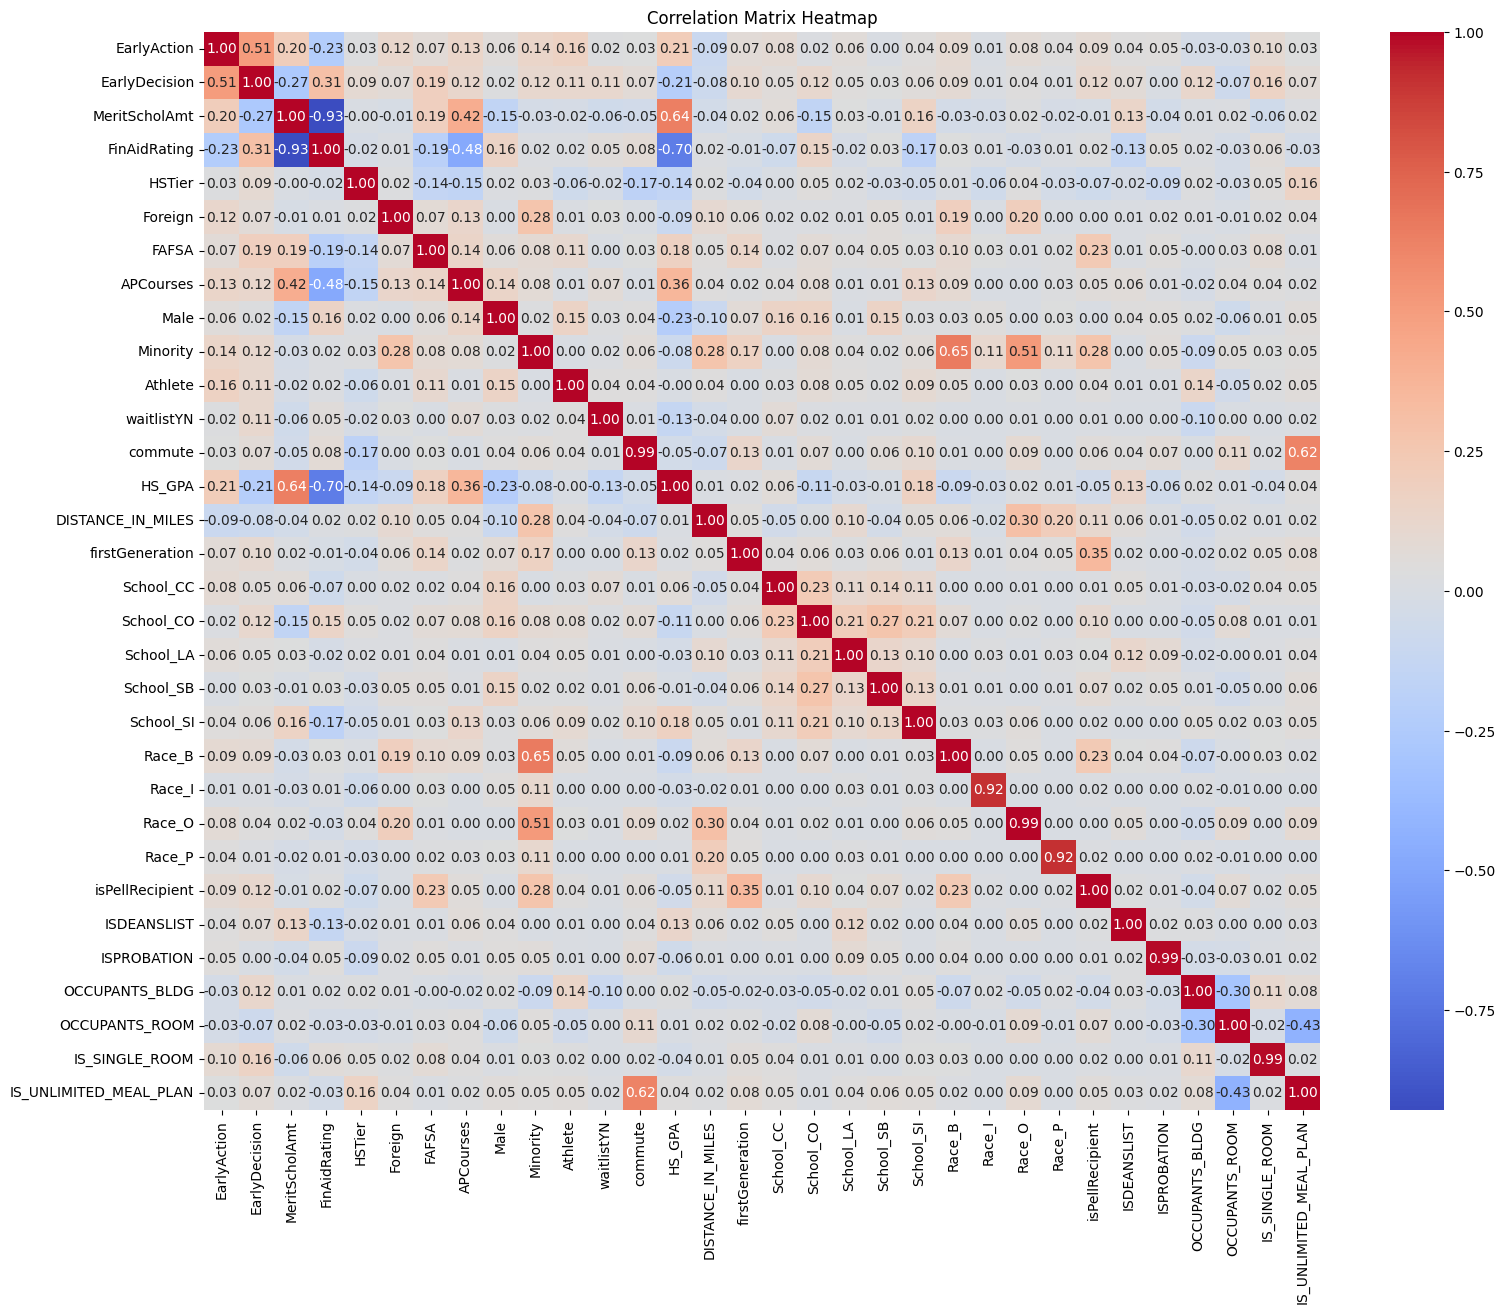

In [19]:
correlation_matrix = mixed_type_correlation_matrix(X_trn_subset)
correlation_matrix
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title('Correlation Matrix Heatmap')
plt.show()

In [59]:
clf = LogisticRegressionStatsModel(X_trn_subset.columns, "Attrited")
clf.fit(X_trn_subset, y_train)

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully.
         Current function value: 0.272033
         Iterations: 294
         Function evaluations: 306
         Gradient evaluations: 300


In [60]:
# Get the top summary and coefficient summary
logreg_summary = clf.get_summary()
coef_summary = clf.get_coef_summary()
# Print the top the summary, Transpose it for better viz.
print(logreg_summary.transpose())
# Print the coefficient summary
coef_summary.reset_index()

                                      0
Dep. Variable                  Attrited
No. Observations                   2430
Method                              MLE
Model                             Logit
Df Residuals                     2397.0
Chi-Square                   398.048938
Chi-Square p-value                  0.0
Df Model (Chi-Square Test)         32.0
Pseudo R-squ.                  0.231407
Log-Likelihood              -661.039654
LL-Null                     -860.064123
LLR p-value                         0.0
AIC                         1388.079307
converged                          True


,index,Coefficient Value,Standard Error,Wald Test Chi2,Wald Test P>|Chi2|,Odds Ratio
0,const,3.706962,2.750146,1.816873,0.1777,40.7299
1,EarlyAction,-0.222200,0.185822,1.429864,0.2318,0.8008
2,EarlyDecision,-0.111770,0.250290,0.199417,0.6552,0.8943
3,MeritScholAmt,-0.145255,0.043211,11.300180,0.0008,0.8648
4,FinAidRating,-0.189710,0.100755,3.545243,0.0597,0.8272
5,HSTier,0.076413,0.120305,0.403427,0.5253,1.0794
6,Foreign,-0.478730,0.411673,1.352307,0.2449,0.6196
7,FAFSA,-0.075327,0.172741,0.190158,0.6628,0.9274
8,APCourses,-0.251757,0.183522,1.881860,0.1701,0.7774
9,Male,0.232468,0.164644,1.993570,0.1580,1.2617


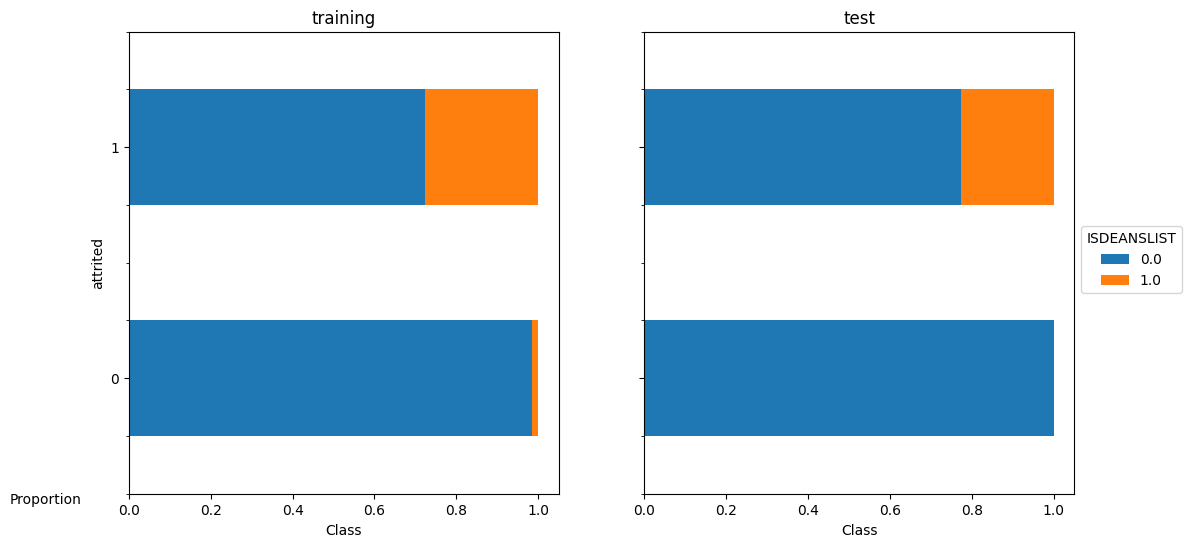

In [61]:
plot_overlayed_proportions(y_train.squeeze(), y_test.squeeze(), 'ISDEANSLIST', Xr_imputed, Xt_imputed)

# Predict on Test Set

In [62]:
# Predict using the test data
probs_test = clf.predict_proba(X_tst_subset)
y_test_pred = clf.predict(X_tst_subset)

In [63]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [64]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1153
           1       0.84      0.24      0.37       150

    accuracy                           0.91      1303
   macro avg       0.87      0.62      0.66      1303
weighted avg       0.90      0.91      0.88      1303





Accuracy.........: 90.7137
Precision........: 83.7209
Recall...........: 24.0000
FP Rate..........: 0.6071
ROC AUC (probs)..: 0.7809
F1 measure.......: 0.3731
Confusion matrix.:
 [[1146    7]
 [ 114   36]]


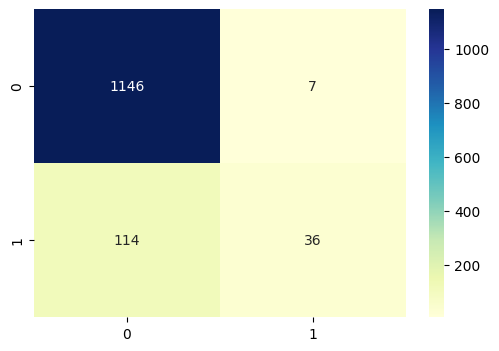

In [65]:
# Report the predictive performance metrics
# evaluate predictions
accuracy = accuracy_score(y_test, y_test_pred)
precision=precision_score(y_test, y_test_pred, pos_label=1)
recall=recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)
specificity=recall_score(y_test, y_test_pred, pos_label=0)
roc = roc_auc_score(y_test, probs_test )

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate..........: {(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc :.4f}")
print(f"F1 measure.......: {f1 :.4f}")

cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion matrix.:\n {cm}")

#This is nicer
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

In [66]:
fpr, tpr, threshold = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)
roc_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_df

,tpr,fpr,threshold
0,0.000000,0.000000,1.930114e+00
1,0.006667,0.000000,9.301138e-01
2,0.073333,0.000000,7.845342e-01
3,0.073333,0.000867,7.844125e-01
4,0.186667,0.000867,6.486848e-01
...,...,...,...
193,0.986667,0.900260,1.815033e-02
194,0.993333,0.900260,1.788000e-02
195,0.993333,0.994796,4.614263e-03
196,1.000000,0.994796,4.287734e-03


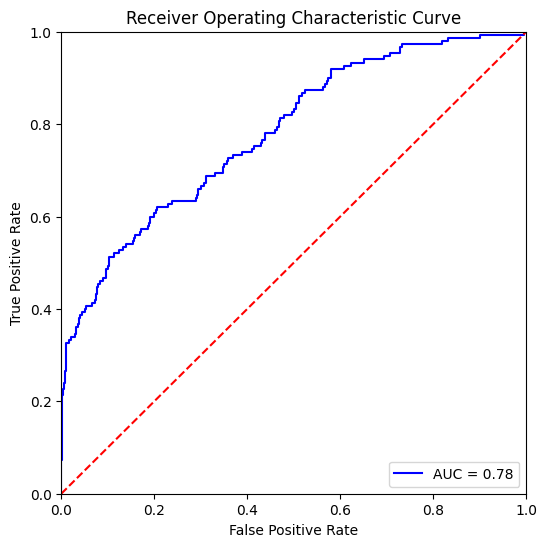

In [67]:
# Create a square figure
plt.figure(figsize=(6, 6))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('ROCcuve.png')
plt.show()

# Show Optimal Cutoffs

In [68]:
#Idenfity appropriate threshold
#roc_df.loc[roc_df.tpr>0.30 & roc_df.tpr <0.40]
#roc_df.loc[(roc_df.fpr<0.1)]
roc_df[roc_df.tpr>0.40]

,tpr,fpr,threshold
40,0.406667,0.053773,2.429629e-01
41,0.406667,0.065048,2.249559e-01
42,0.413333,0.065048,2.231881e-01
43,0.413333,0.072853,2.152273e-01
44,0.420000,0.072853,2.141409e-01
...,...,...,...
193,0.986667,0.900260,1.815033e-02
194,0.993333,0.900260,1.788000e-02
195,0.993333,0.994796,4.614263e-03
196,1.000000,0.994796,4.287734e-03


In [69]:
# make predictions for test data
#predictions = model.predict(X_test,ntree_limit=model.best_ntree_limit)  # not using it to vary the threshold

# Confusion Matrix



Accuracy.........: 86.7229
Precision........: 42.3841
Recall...........: 42.6667
FP Rate..........: 7.5455
ROC AUC (probs)..: 0.7809
F1 measure.......: 0.4252
Confusion matrix.:
 [[1146    7]
 [ 114   36]]


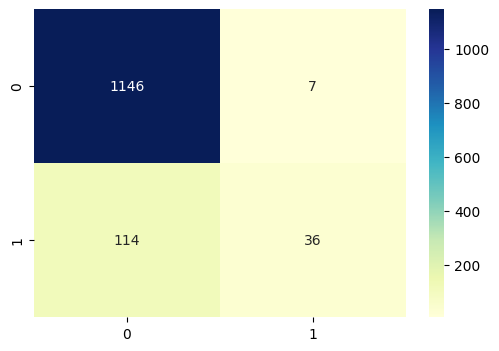

In [70]:
cutoff = 0.21 # picked from above
predictions = (probs_test >cutoff).astype(int)

# Report the predictive performance metrics
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, pos_label=1)
recall=recall_score(y_test, predictions, pos_label=1)
f1 = f1_score(y_test, predictions, pos_label=1)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs_test )

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate..........: {(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc :.4f}")
print(f"F1 measure.......: {f1 :.4f}")

cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion matrix.:\n {cm}")

#This is nicer
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");

In [70]:
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chi2
from scipy.stats import norm

class LogisticRegressionStatsModel_with_feature_selection:
    def __init__(self, feature_names, target_name):
        self.feature_names = feature_names
        self.target_name = target_name
        self.X_columns = None
        self.model = None
        self.results = None

    def _forward_selection(self, X, y, p_value_threshold=0.05):
        initial_features = X.columns.tolist()
        best_features = []
        features_to_select_from = initial_features.copy()

        while features_to_select_from:
            p_values_with_candidates = {}
            for feature in features_to_select_from:
                tested_features = best_features + [feature]
                tested_model = sm.Logit(y, sm.add_constant(X[tested_features])).fit(disp=0)
                p_value = tested_model.pvalues[feature]
                p_values_with_candidates[feature] = p_value

            best_feature, best_p_value = min(p_values_with_candidates.items(), key=lambda x: x[1])
            if best_p_value < p_value_threshold:
                best_features.append(best_feature)
                features_to_select_from.remove(best_feature)
            else:
                break

        return best_features

    def fit(self, X_train, y_train, stepwise=False):
        if stepwise:
            selected_features = self._forward_selection(X_train, y_train)
            X_train = X_train[selected_features]
        X_train = sm.add_constant(X_train)
        model = sm.Logit(y_train, X_train)
        self.results = model.fit(maxiter=500, method='bfgs') #bfgs
        self.model = model
        self.X_columns = X_train.columns

    def predict_proba(self, X_data):
        X_data= X_data[self.X_columns]
        X_data = sm.add_constant(X_data)
        return self.results.predict(X_data)

    def predict(self, X_data, threshold=0.5):
        X_data= X_data[self.X_columns]
        probabilities = self.predict_proba(X_data)
        return (probabilities >= threshold).astype(int)

    def get_summary(self):
        top_summary_data = {
            'Dep. Variable': self.target_name,
            'No. Observations': len(self.X_columns) - 1,  # Subtracting the constant
            'Method': 'MLE',
            'Model': 'Logit',
            'Df Residuals': self.results.df_resid,
            'Chi-Square': self.results.llr,
            'Chi-Square p-value': self.results.llr_pvalue,
            'Df Model (Chi-Square Test)': self.results.df_model,
            'Pseudo R-squ.': self.results.prsquared,
            'Log-Likelihood': self.results.llf,
            'LL-Null': self.results.llnull,
            'LLR p-value': self.results.llr_pvalue,
            'AIC': self.results.aic,
            'converged': self.results.mle_retvals['converged']
        }
        summary = pd.DataFrame([top_summary_data])
        return summary

    def get_coef_summary(self):
        wald_chi2 = (self.results.params / self.results.bse)**2
        wald_p_values = 1 - chi2.cdf(wald_chi2, df=1)

        coef_summary_data = {
            'Coefficient Value': self.results.params,
            'Standard Error': self.results.bse,
            'Wald Test Chi2': wald_chi2,
            'Wald Test P>|Chi2|': np.round(wald_p_values, 4),
            'Odds Ratio': np.round(np.exp(self.results.params), 4)
        }
        coef_summary = pd.DataFrame(coef_summary_data, index=self.X_columns)
        return coef_summary

# Example usage
# model = LogisticRegressionStatsModel(feature_names, target_name)
# model.fit(X_train, y_train, stepwise=True)
# summary = model.get_summary()
# coef_summary = model.get_coef_summary()
# print(summary)
# print(coef_summary)